In [ ]:
!pip install earthpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 15.7 MB/s 
     |████████████████████████████████| 19.3 MB 1.3 MB/s 
     |████████████████████████████████| 1.0 MB 50.4 MB/s 
     |████████████████████████████████| 16.7 MB 54.9 MB/s 
     |████████████████████████████████| 6.3 MB 45.4 MB/s 


In [ ]:
import earthpy.plot as ep
import earthpy as et
import earthpy.spatial as es
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from google.colab import files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the .mat file with loadmat

In [ ]:
#taken by the 224 band AVIRIS with 20 bands removed for water absorption

data = loadmat('/content/drive/My Drive/DAT690/Salinas_corrected.mat')['salinas_corrected']

gt = loadmat('/content/drive/My Drive/DAT690/Salinas_gt.mat')['salinas_gt']

print(f'Data Shape: {data.shape}\nNumber of Bands: {data.shape[-1]}')

print(f'Groundtruthing Shape: {gt.shape}')

Data Shape: (512, 217, 204)
Number of Bands: 204
Groundtruthing Shape: (512, 217)


In [ ]:
def combineData(imagedata, groundtruthed):

#preprocessing the data from a 3d matrix into a 2d matrix for dimensionality reduction and combining the datasets

  df = pd.DataFrame(data.reshape(imagedata.shape[0]*imagedata.shape[1], -1))

#transforming the class data from the groundtruthing .mat file to one column and converting the groundtruth data to a dataFrame

  Class = pd.DataFrame(groundtruthed.ravel())

  gt_frame = pd.DataFrame(groundtruthed)

#adding the class indicator to the dataframe

  df["Class"] = Class

#shift the axis so that the bands are at the beginning and it only displays one at a time

  mdata = np.moveaxis(data, -1, 0)

#Printing the shapes of the data

  print(f'gtframe Data Shape: {gt_frame.shape}')
  print(f'mdata Data Shape: {mdata.shape}')
  print(f'df Data Shape: {df.shape}')

  return df, gt_frame, mdata

In [ ]:
df, gt_frame, mdata = combineData(data, gt)

gtframe Data Shape: (512, 217)
mdata Data Shape: (204, 512, 217)
df Data Shape: (111104, 205)


In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,195,196,197,198,199,200,201,202,203,Class
0,290,381,585,1041,1316,1397,1319,1462,1643,1683,...,96,109,93,54,79,54,36,11,17,0
1,290,381,519,1041,1316,1352,1319,1462,1643,1683,...,94,111,96,56,83,56,36,11,15,0
2,290,381,585,1041,1286,1352,1300,1412,1614,1644,...,88,107,89,54,81,54,30,11,11,0
3,290,381,585,999,1316,1374,1280,1380,1584,1631,...,86,105,85,56,75,50,30,11,19,0
4,219,381,585,999,1286,1352,1261,1396,1555,1618,...,83,105,83,48,75,50,24,9,17,0


## Data Exploration

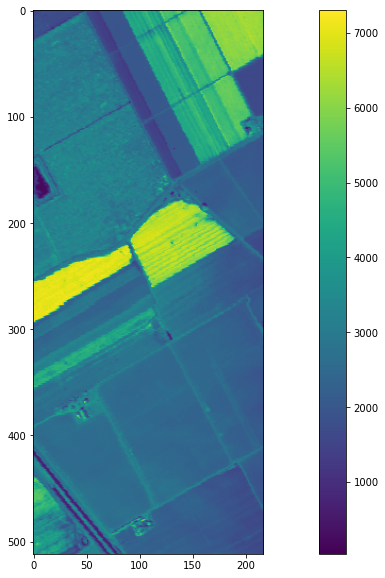

In [ ]:
#Visualizing some of the bands available

plt.figure()
plt.imshow(mdata[50])
plt.colorbar()

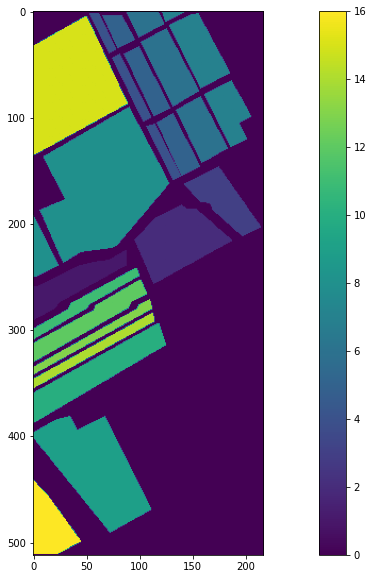

In [ ]:
#ground truthed image so this is our y

plt.figure()
plt.imshow(gt)
plt.colorbar()

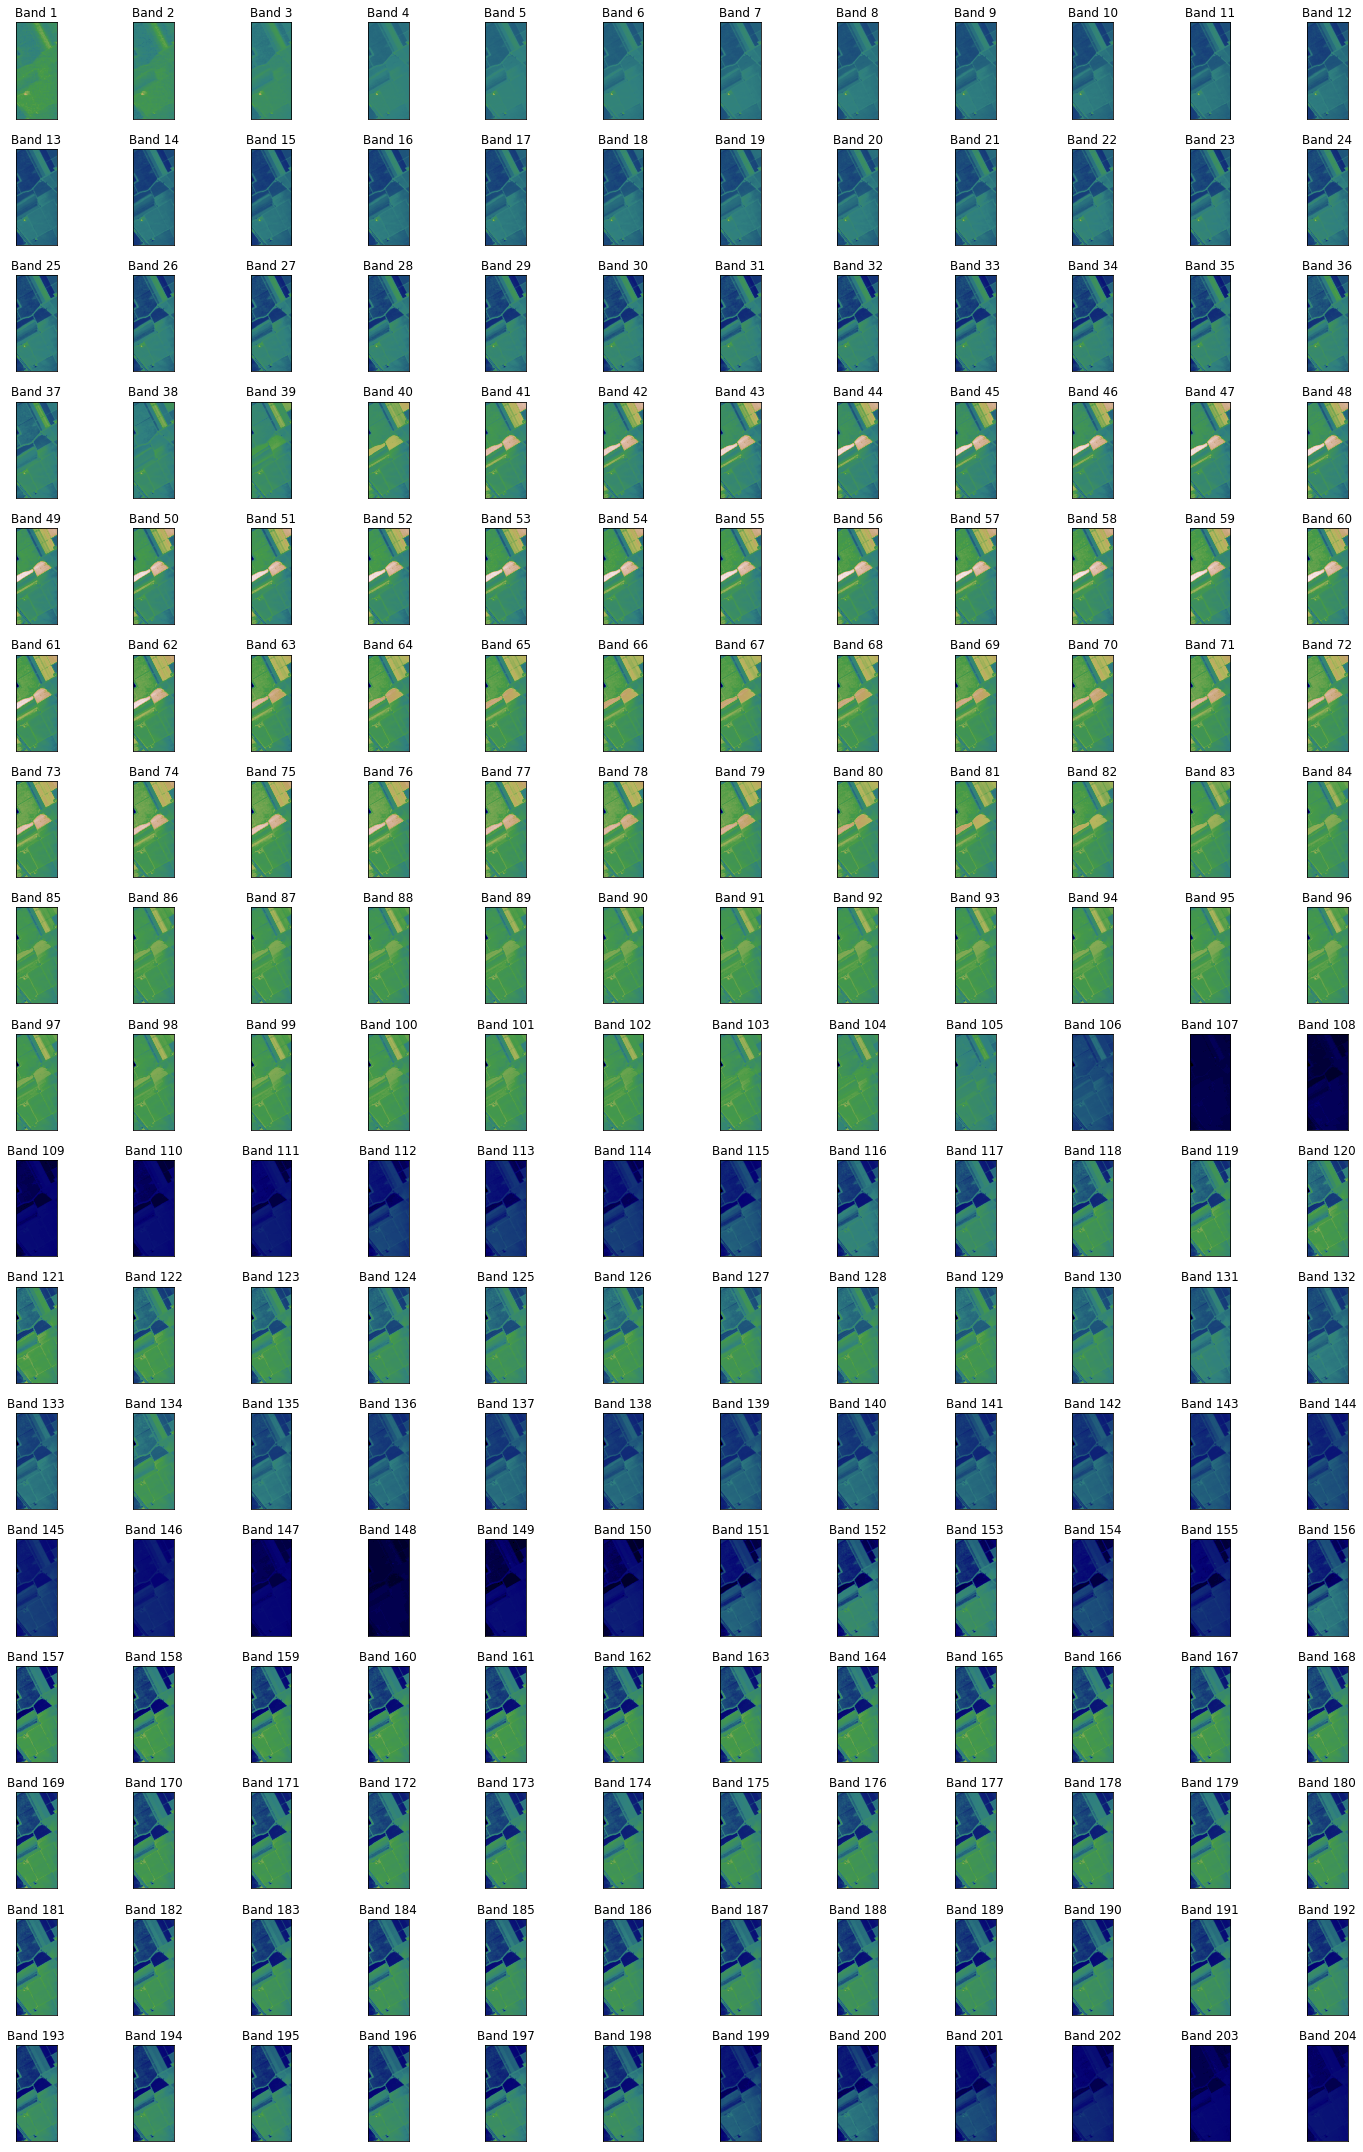

In [ ]:
ep.plot_bands(mdata, 
              cmap = 'gist_earth', 
              figsize = (20, 30), 
              cols = 12, 
              cbar = False)
plt.show()

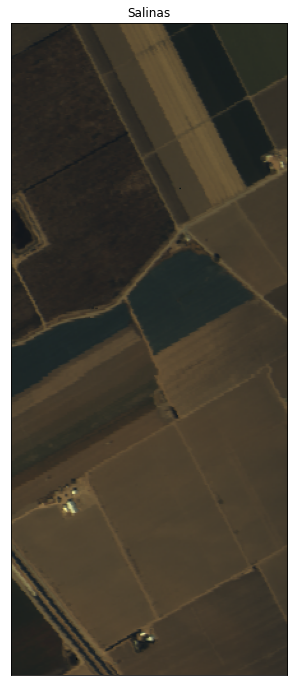

In [ ]:
# Create figure with one plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot red, green, and blue bands, respectively. Shows visible spectrum.
ep.plot_rgb(mdata, rgb=(25, 15, 6), ax=ax, title="Salinas")
plt.show()

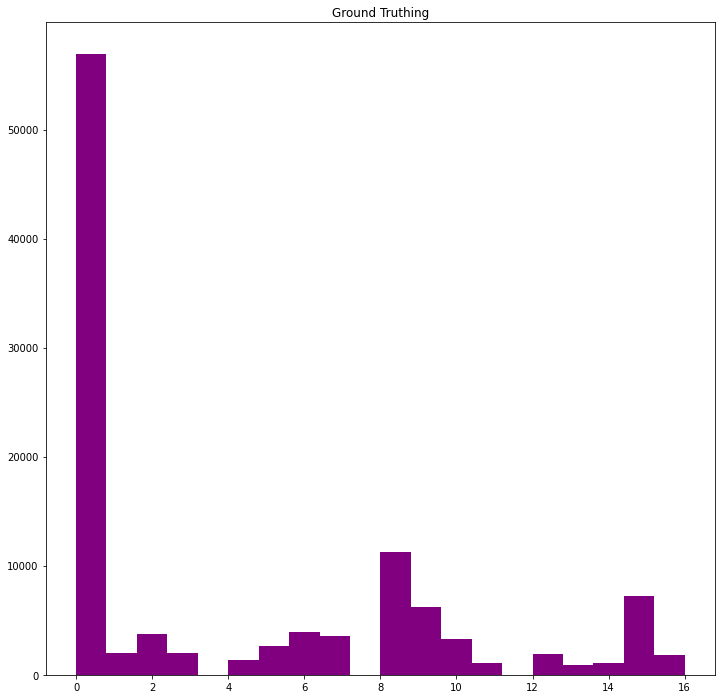

In [ ]:
#graphing the ground truthing data to show what type of landusage is available

ep.hist(gt, title="Ground Truthing")
plt.show()

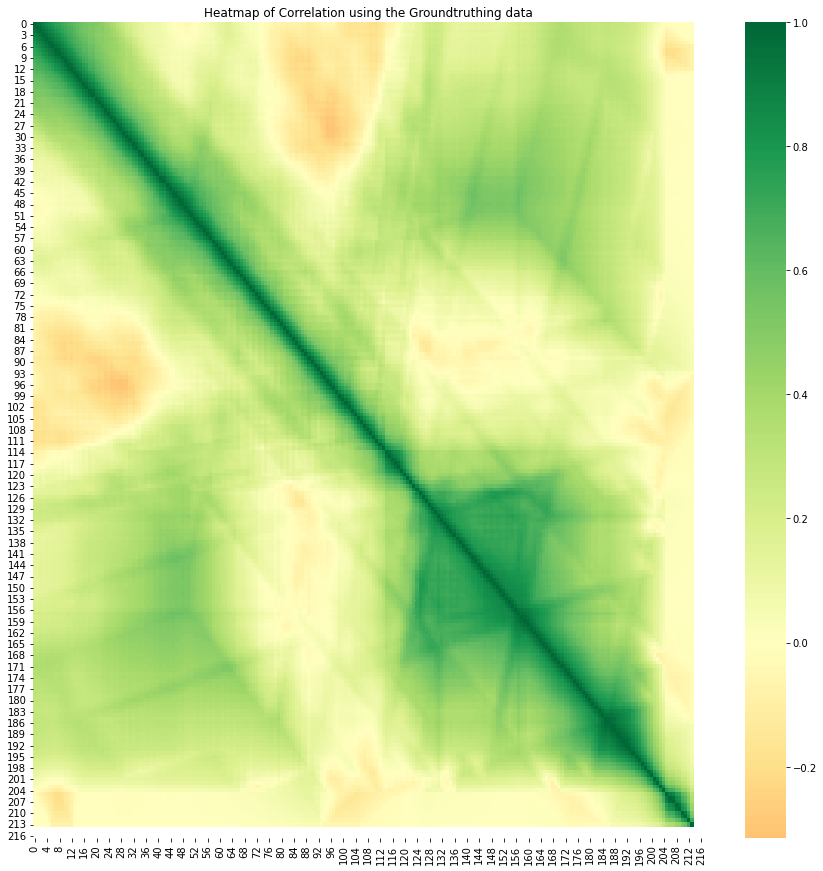

In [ ]:
#Visualizing the relationship between the different landusage categories

plt.figure(figsize=(15,15))
plt.title("Heatmap of Correlation using the Groundtruthing data")
p=sns.heatmap(gt_frame.corr(), annot=False,cmap='RdYlGn',center=0) 

## Splitting the data for training and testing

In [ ]:
def preprocessing(dataset):

#preprocessing the dataset to reduce dimensionality and then setting X and y

  new_df = dataset[dataset["Class"] != 0]

  X = new_df.loc[:, new_df.columns != 'Class']
  y = new_df["Class"].astype("category")

#Splitting the data into training and testing data, 80% training, 20% testing

  X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#Further subsetting the training data into training and validation data for use while training the CNN

  X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
  y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

  input_shape = X_train.shape[1]

  return X_train, y_train, X_valid, y_valid, X_test, y_test, input_shape

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test, input_shape = preprocessing(df)

In [ ]:
X_test.shape

(10826, 204)

## Building and Training the Model

In [ ]:
def buildnet(optimizer, loss, metrics):
  #Building the CNN model

  model = keras.models.Sequential([
                                  keras.layers.Conv1D(256, 3, activation = "selu", kernel_initializer = "lecun_normal", input_shape = [input_shape, 1], padding = "same"),
                                  keras.layers.Conv1D(256, 3, activation = "selu", kernel_initializer = "lecun_normal", padding = "same"),
                                  keras.layers.Conv1D(256, 3, activation = "selu", kernel_initializer = "lecun_normal", padding = "same"),

                                  keras.layers.MaxPool1D(2),
                                  keras.layers.BatchNormalization(),

                                  keras.layers.Conv1D(128, 3, activation = "selu", kernel_initializer = "lecun_normal", padding = "same"),
                                  keras.layers.Conv1D(128, 3, activation = "selu", kernel_initializer = "lecun_normal", padding = "same"),
                                  keras.layers.Conv1D(128, 3, activation = "selu", kernel_initializer = "lecun_normal", padding = "same"),

                                  keras.layers.MaxPool1D(2),
                                  keras.layers.BatchNormalization(),

                                  keras.layers.Conv1D(64, 3, activation = "selu", kernel_initializer = "lecun_normal", padding = "same"),
                                  keras.layers.Conv1D(64, 3, activation = "selu", kernel_initializer = "lecun_normal", padding = "same"),
                                  keras.layers.Conv1D(64, 3, activation = "selu", kernel_initializer = "lecun_normal", padding = "same"),

                                  keras.layers.Flatten(),
                                  keras.layers.Dense(128, activation = "selu", kernel_initializer = "lecun_normal"),
                                  keras.layers.Dropout(0.4),
                                  keras.layers.Dense(64, activation = "selu", kernel_initializer = "lecun_normal"),
                                  keras.layers.Dropout(0.4),
                                  keras.layers.Dense(17, activation="softmax")
  ])

  #Model Summary

  model.summary()

  #Creating callbacks for early stopping and checkpoints so that we can get the best model possible

  early_stop = keras.callbacks.EarlyStopping(patience=20, restore_best_weights = True)
  checkpoint = keras.callbacks.ModelCheckpoint("LandUse_CNN.h5")

  #Compiling the model using the NADAM optimizer and sparse_categorical_crossentropy

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

  #model built and compiled

  print("\n Model built and compiled")

  return model, early_stop, checkpoint

In [ ]:
model, early_stop, checkpoint = buildnet("Nadam", "sparse_categorical_crossentropy", ["accuracy"])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_27 (Conv1D)          (None, 204, 256)          1024      
                                                                 
 conv1d_28 (Conv1D)          (None, 204, 256)          196864    
                                                                 
 conv1d_29 (Conv1D)          (None, 204, 256)          196864    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 102, 256)         0         
 1D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 102, 256)         1024      
 hNormalization)                                                 
                                                                 
 conv1d_30 (Conv1D)          (None, 102, 128)         

In [ ]:
#training the model with 50 epochs

history = model.fit(X_train, y_train, epochs=50, callbacks=[early_stop, checkpoint],
          validation_data=(X_valid,y_valid))

Epoch 1/50
1197/1197 [==============================] - 27s 18ms/step - loss: 1.0775 - accuracy: 0.6567 - val_loss: 0.5552 - val_accuracy: 0.7708
Epoch 2/50
1197/1197 [==============================] - 21s 18ms/step - loss: 0.5451 - accuracy: 0.7819 - val_loss: 0.4018 - val_accuracy: 0.8306
Epoch 3/50
1197/1197 [==============================] - 20s 17ms/step - loss: 0.4741 - accuracy: 0.8041 - val_loss: 0.3519 - val_accuracy: 0.8328
Epoch 4/50
1197/1197 [==============================] - 20s 17ms/step - loss: 0.4301 - accuracy: 0.8212 - val_loss: 0.3152 - val_accuracy: 0.8760
Epoch 5/50
1197/1197 [==============================] - 22s 18ms/step - loss: 0.3925 - accuracy: 0.8386 - val_loss: 0.2938 - val_accuracy: 0.8766
Epoch 6/50
1197/1197 [==============================] - 21s 17ms/step - loss: 0.3677 - accuracy: 0.8488 - val_loss: 0.7192 - val_accuracy: 0.8000
Epoch 7/50
1197/1197 [==============================] - 21s 17ms/step - loss: 0.3530 - accuracy: 0.8559 - val_loss: 0.2460 -

In [ ]:
model.save("LandUse_CNN.h5")

In [ ]:
files.download('LandUse_CNN.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model Evaluation and Results

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn import metrics

In [ ]:
def evalNet(model, X_test, y_test):
  #Loading the model from the save file

  model = keras.models.load_model(model)

  #evaluating the model

  model.evaluate(X_test, y_test)

  #Saving the predictions and taking the highest probability of each one

  y_pred = np.argmax(model.predict(X_test), axis=1)

  #converting to a pandas dataframe to make it easier to use

  y_pred = pd.DataFrame(y_pred.ravel())

  #Converting the testing data to a pandas dataframe to make it easier to use

  y_test = pd.DataFrame(y_test)

  #Confusion Matrix of the test data

  print("\n", "Accuracy:",metrics.accuracy_score(y_test, y_pred), "\n")

  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.title('Land Usage CNN Classification Confusion Matrix')
  plt.figure(figsize = (15,15))
  plt.show()

  #Running precision, recall, and f1 scores for each class to determine accuracy of the classifier

  precision = precision_score(y_test, y_pred, average = None)
  recall = recall_score(y_test, y_pred, average = None)
  f1Score = f1_score(y_test, y_pred, average = None)

  print("\n", f"Precision Scores: {precision}", "\n")
  print(f"Recall Scores: {recall}", "\n")
  print(f"f1 Scores: {f1Score}")

339/339 [==============================] - 2s 6ms/step - loss: 0.1921 - accuracy: 0.9222

 Accuracy: 0.9222242748937742 



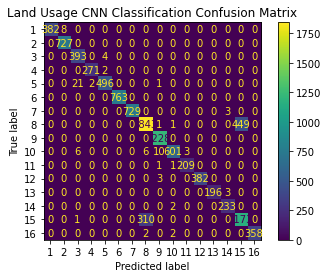

<Figure size 1080x1080 with 0 Axes>


 Precision Scores: [1.         0.98911565 0.93349169 0.99267399 0.98804781 1.
 1.         0.8528459  0.98713826 0.99011532 0.98584906 1.
 1.         0.9748954  0.72318126 1.        ] 

Recall Scores: [0.97948718 1.         0.98992443 0.99267399 0.95384615 1.
 0.99590164 0.80340017 1.         0.9600639  0.99052133 0.99220779
 0.98492462 0.99148936 0.79043127 0.98895028] 

f1 Scores: [0.98963731 0.99452804 0.9608802  0.99267399 0.97064579 1.
 0.99794661 0.82738496 0.99352751 0.97485807 0.98817967 0.99608866
 0.99240506 0.98312236 0.7553123  0.99444444]


In [ ]:
evalNet("/content/drive/My Drive/DAT690/LandUse_CNN.h5", X_test, y_test)

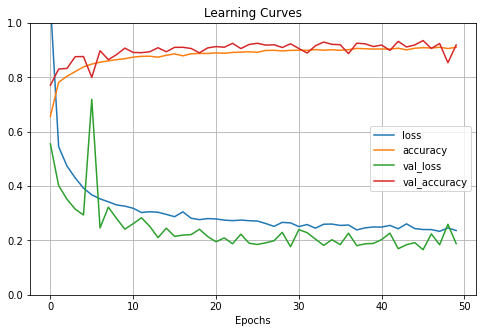

In [ ]:
#Learning curves of the training of the CNN, this shows us how accurate and how close to the minima the CNN gets

pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("Learning Curves")
plt.xlabel("Epochs")
plt.show()

## Filter Visualization



In [ ]:
def visualizeFilter():
  # summarize filter shapes
  for layer in model.layers:
	# check for convolutional layer
	  if 'conv' not in layer.name:
		  continue
	# get filter weights
	  filters, biases = layer.get_weights()
	  print(layer.name, filters.shape)
 
  # retrieve weights from the second hidden layer
  filters, biases = model.layers[1].get_weights()

  # normalize filter values to 0-1 so we can visualize them
  f_min, f_max = filters.min(), filters.max()
  filters = (filters - f_min) / (f_max - f_min)

  #Size of figure
  plt.rcParams['figure.figsize'] = (20, 10)
  #Title
  plt.title("Visualizing the filters of the CNN")
  #Generating the image of 6 different filters that are applied in the CNN
  for i in range(6): 
    plt.imshow(filters[:,i])
    plt.axis('on')
    plt.show()

conv1d_27 (3, 1, 256)
conv1d_28 (3, 256, 256)
conv1d_29 (3, 256, 256)
conv1d_30 (3, 256, 128)
conv1d_31 (3, 128, 128)
conv1d_32 (3, 128, 128)
conv1d_33 (3, 128, 64)
conv1d_34 (3, 64, 64)
conv1d_35 (3, 64, 64)


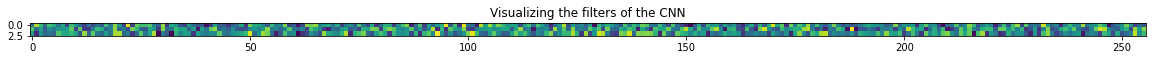

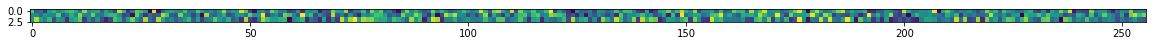

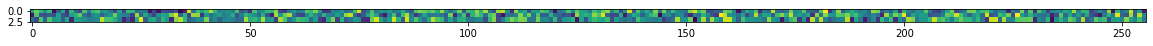

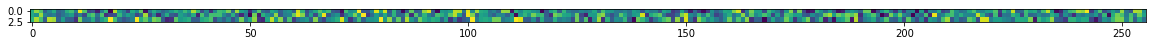

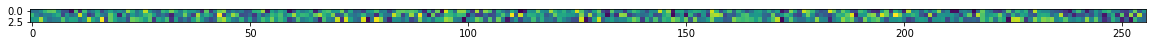

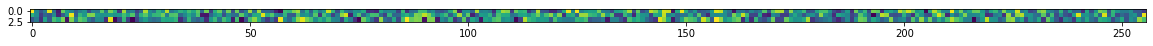

In [ ]:
visualizeFilter()

## Feature Visualization

In [ ]:
def visualizeFeature():
  for i in range(len(model.layers)):
	  layer = model.layers[i]
	  # check for convolutional layer
	  if 'conv' not in layer.name:
		  continue
	  # summarize output shape
	  print(layer.name, layer.output.shape)
   
  from keras.models import Model

	# redefine model to output right after the first hidden layer
  model1 = Model(inputs=model.inputs, outputs=model.layers[1].output)
  model1.summary()
	# get feature map for first hidden layer
  feature_maps = model1.predict(X_test)
	#feature_maps = np.transpose(feature_maps)
	#Title
  plt.title("Visualizing the features of the CNN")
	#Generating the feature image for 6 different outputs from the model
  for i in range(6): 
  	plt.imshow(feature_maps[:,i])
  	plt.axis('on')
  	plt.ylim(0,200)
  	plt.show()

  return model1

In [ ]:
model1 = visualizeFeature()

Output hidden; open in https://colab.research.google.com to view.